<a href="https://colab.research.google.com/github/Filippo-Tombari/PdeGraph/blob/main/basic_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Risolviamo numericamente l'equazione

\begin{equation}
\frac{\partial u}{\partial t} - \Delta u + \mathbf{b}\cdot\nabla u= 0
\end{equation}

dove $\mathbf{b}=[0,1]$. Al bordo consideriamo condizioni di Neumann omogenee. Usiamo

\begin{equation}
u_{0}(x,y) = (x+1)^{2} + (y+1)^{2},
\end{equation}

come profilo iniziale.

Applicando il metodo di Eulero all'indietro in tempo abbiamo

\begin{equation}
\frac{u^{n+1} - u^{n}}{\Delta t} - \Delta u^{n+1} + \mathbf{b}\nabla u^{n+1} = 0,
\end{equation}

da cui

\begin{equation}
\implies u^{n+1} - \Delta t\Delta u^{n+1} + \Delta t\mathbf{b}\nabla u^{n+1} = u^{n}.
\end{equation}


# Import the necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append("/content/drive/MyDrive/tesi/PdeGraph")
import os
os.chdir("/content/drive/MyDrive/tesi/PdeGraph")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import install
install.pytorchgeo()

Pytorch geometric installed.


In [ ]:
install.fenics()

FEniCS installed.


In [ ]:
import numpy as np
import functional
from functional import asfield, plot, L2
from gnns import Encoder, Decoder, Sequential
from utils import buildconnectivity, initialize_weights, train, forecast
import dolfin
import torch
import torch.optim as optim
import imageio
import matplotlib.pyplot as plt

# Loading and preparation of the data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
mesh_train = dolfin.cpp.mesh.Mesh("files/geometry.xml")
mesh_test = dolfin.cpp.mesh.Mesh("files/geometry_test.xml")
edge_index_train = buildconnectivity(mesh_train)
edge_index_train = torch.t(torch.from_numpy(edge_index_train.astype('int32')).long()).to(device)
edge_index_test = buildconnectivity(mesh_test)
edge_index_test = torch.t(torch.from_numpy(edge_index_test.astype('int32')).long()).to(device)
#create festures matrices
fts_train = torch.from_numpy(np.load("files/traiettoria.npy")).float().unsqueeze(dim = 2).to(device)
fts_test = torch.from_numpy(np.load("files/traiettoria_test.npy")).float().unsqueeze(dim = 2).to(device)

print("training edge connectivity matrix shape: ", edge_index_train.shape)
print("test edge connectivity matrix shape: ", edge_index_test.shape)
print("training feature matrix shape:", fts_train.shape)
print("test feature matrix shape:", fts_test.shape)

training edge connectivity matrix shape:  torch.Size([2, 7379])
test edge connectivity matrix shape:  torch.Size([2, 28536])
training feature matrix shape: torch.Size([11, 2553, 1])
test feature matrix shape: torch.Size([11, 9698, 1])


In [ ]:
bmesh = dolfin.BoundaryMesh(mesh_train, "exterior", True)
n_b_nodes = bmesh.coordinates().shape[0]

In [ ]:
bindex = torch.zeros(fts_train.shape).to(device)
bindex[:,:n_b_nodes,0] = 1
fts_train = torch.cat((fts_train,bindex),2)

In [ ]:
edge_weights_train = initialize_weights(edge_index_train,mesh_train).to(device)
edge_weights_train.shape

torch.Size([7379, 3])

# Training

In [ ]:
l2   = L2(mesh_train).float() # L2 norm for scalar functions
lv22 = lambda v: l2(v[:,:,0].to(device)).pow(2).float() + l2(v[:,:,1].to(device)).pow(2).float()
lv2  = lambda v: lv22(v).sqrt().float() # L2 norm for vectorial functions
def loss(output, target):
  return (l2(target - output)/l2(target)).mean().float()

In [ ]:
latent_size = 32
nh = mesh_train.num_vertices()
net = Sequential(Encoder(2,3,latent_size,nh),Decoder(latent_size,3,latent_size,nh))
net.to(device)

Sequential(
  (0): Encoder(
    (mlp_node): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (mlp_edge): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (gnn): Sequential(
      (0): EdgeConv()
      (1): EdgeConv()
    )
    (mlp_graph): Sequential(
      (0): Flatten(start_dim=0, end_dim=1)
      (1): Linear(in_features=81696, out_features=32, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
  )
  (1): Decoder(
    (mlp_node): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
    (mlp_edge): Seq

In [ ]:
for g in net:
  try:
      torch.nn.init.kaiming_normal_(g.weight, mode='fan_out', nonlinearity='leaky_relu', a=0.1)
  except:
      None 



In [ ]:
learningrate = 1e-3
adam = optim.Adam(net.parameters(), lr=learningrate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.5,patience=30)
lbfgs = optim.LBFGS(net.parameters()) 
model_chk_path = 'checkpoints/basic_chk_integranda.pt'
#first 500 epochs with adam 
train(net,fts_train,edge_index_train,edge_weights_train,loss,adam,model_chk_path,epochs=500,dt=0.1)
#last 500 epochs with lbfgs
net = torch.load('checkpoints/basic_chk_integranda.pt')
train(net,fts_train,edge_index_train,edge_weights_train,loss,lbfgs,model_chk_path,epochs=500,dt=0.1)

Rollout 1.000000: MSE_train 0.394798
Saving model checkpoint


KeyboardInterrupt: ignored

In [ ]:
net = torch.load('checkpoints/basic_chk_integranda.pt')

In [ ]:
U = forecast(fts_train[0], net, fts_train, edge_index_train, edge_weights_train, steps = 10, dt = 0.1)

In [ ]:
loss(U[:,:,0],fts_train[:,:,0])

tensor(0.0002, device='cuda:0')

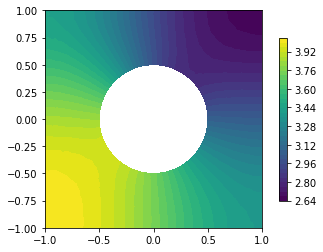

In [ ]:
colorbar = plot(functional.asfunction(U[-1,:,0],mesh_train))
plt.colorbar(colorbar, shrink = 0.75)

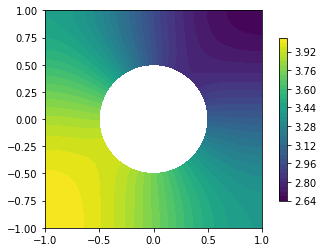

In [ ]:
colorbar = plot(functional.asfunction(fts_train[-1,:,0],mesh_train))
plt.colorbar(colorbar, shrink = 0.75)

In [ ]:
# Righe di codice per salvare l'animazione in formato .gif
def savegif(drawframe, frames, name, transparency = False, remove = True):
    filenames = []
    for i in range(frames):
        # plot frame
        drawframe(i)

        # create file name and append it to a list
        filename = f'{i}.png'
        filenames.append(filename)

        # save frame
        plt.savefig(filename, transparency = transparency)
        plt.close()
    # build gif
    with imageio.get_writer(name + '.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Remove files
    if(remove):
        for filename in set(filenames):
            os.remove(filename)

def trajectorytogif(traj, dt, name):
    def drawframe(i):
        colorbar = plot(functional.asfunction(traj[i,:,0].cpu(), mesh_train))
        plt.colorbar(colorbar, shrink = 0.75)
        plt.title("T = %.2f" % (dt*i))
        plt.axis("off")
    savegif(drawframe, frames = len(traj), name = name)

In [ ]:
trajectorytogif(U, 0.1, name = "images/basic_example_pred_integranda_3") # crea e salva la gif (la si trova nella cartella dei file generati, a sx del notebook)

# Nota: su Colab non si può, ma su jupyter notebook è invece possibile visualizzare poi la gif direttamente
# dentro il notebook, e.g.

# from  IPython.display import Image as show
# show("esempio.gif")

In [ ]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   basic_example.ipynb
	deleted:    checkpoints/basic_chk.pt
	deleted:    checkpoints/basic_chk_best.pt
	deleted:    checkpoints/basic_chk_noint.pt
	deleted:    checkpoints/basic_chk_pre.pt
	deleted:    images/basic - prediction (train).gif
	deleted:    images/basic_example_pred.gif
	deleted:    images/basic_example_pred_integranda.gif
	deleted:    images/basic_example_train.gif
	deleted:    images/basic_example_train_integranda.gif
	deleted:    images/test_basic_example_gt.gif
	deleted:    images/test_basic_example_pred.gif
	deleted:    images/test_basic_example_pred_train.gif

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	checkpoints/basic_chk_integrand

In [ ]:
!git config --global user.email "filo.tombari@gmail.com"
!git config --global user.name "Filippo-Tombari"

In [ ]:
!git pull 

Already up to date.


In [ ]:
!git add .
!git commit -m "modifiche caso base"
!git push -u origin main

[main e4a1927] modifiche caso base
 15 files changed, 1 insertion(+), 1 deletion(-)
 rewrite basic_example.ipynb (96%)
 delete mode 100644 checkpoints/basic_chk.pt
 delete mode 100644 checkpoints/basic_chk_best.pt
 create mode 100644 checkpoints/basic_chk_integranda_best.pt
 delete mode 100644 checkpoints/basic_chk_noint.pt
 delete mode 100644 checkpoints/basic_chk_pre.pt
 delete mode 100644 images/basic - prediction (train).gif
 rename images/{test_basic_example_gt.gif => basic_example_gt.gif} (100%)
 delete mode 100644 images/basic_example_pred.gif
 delete mode 100644 images/basic_example_pred_integranda.gif
 create mode 100644 images/basic_example_pred_integranda_best.gif
 delete mode 100644 images/basic_example_train.gif
 delete mode 100644 images/basic_example_train_integranda.gif
 delete mode 100644 images/test_basic_example_pred.gif
 delete mode 100644 images/test_basic_example_pred_train.gif
Counting objects: 35, done.
Delta compression using up to 2 threads.
Compressing object